In [ ]:
# This is walkthrough of how to query Gaia data in a Jupyter environment + how to make aitoff projection 
# plots using a combination of our derived dataset and the Gaia queried data. Warning: Not a perfect "plug 
# and chug" example, so use with caution and please make improvements!

In [1]:
from astroquery.gaia import Gaia
import pandas as pd
import numpy as np
import dask.dataframe as dd
import glob
import os

from astropy import units as u
from astropy.coordinates import (SkyCoord, Distance, Galactic, EarthLocation, AltAz)
import astropy.coordinates as coord
from astropy.coordinates import ICRS, Galactic

import matplotlib.pyplot as plt;
import matplotlib as mpl;
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.cm as cm;
import matplotlib.colors as colors
get_ipython().run_line_magic('matplotlib', 'inline')
cmap = mpl.rcParams['xtick.labelsize'] = 12;mpl.rcParams['ytick.labelsize'] = 12;mpl.rcParams['font.weight'] = 'medium';mpl.rcParams['axes.linewidth'] = 1.5;mpl.rcParams['xtick.major.width'] = 1.5;mpl.rcParams['xtick.minor.width'] = 0.75;mpl.rcParams['xtick.minor.visible'] = True;mpl.rcParams['ytick.major.width'] = 1.5;mpl.rcParams['ytick.minor.width'] = 0.75;mpl.rcParams['ytick.minor.visible'] = True
%config InlineBackend.figure_format = 'retina' #better quality plots

In [2]:
# This is our dataset of derived labels (pre-cleaned)
clean = pd.read_hdf('clean_rvs_params.h5')

In [5]:
# You can see there is currently no kinematic info in this dataset
clean.keys()

Index(['source_id', 'model_teff', 'model_logg', 'model_feh', 'model_mgfe',
       'model_sife', 'model_cafe', 'model_nife', 'err_teff', 'err_logg',
       'err_feh', 'err_mgfe', 'err_sife', 'err_cafe', 'err_nife', 'SNR',
       'chisqs'],
      dtype='object')

In [6]:
IDs = list(clean['source_id'])

In [7]:
# This is how many stars are in the clean dataset
print(len(IDs))

708769


In [2]:
# Source: https://astronomy.stackexchange.com/questions/46892/query-gaia-by-star-name
# ---------------------------------------------------------------------------

def GetGAIAData(GaiaDR3SourceIDs, n):
    # gets the GAIA data for the provided GaiaDR2SourceIDs's
    # and writes to a local CSV
        
    dfGaia = pd.DataFrame()
    
    #job = Gaia.launch_job_async( "select top 100 * from gaiadr2.gaia_source where parallax>0 and parallax_over_error>3. ") # Select `good' parallaxes
    # !!! Modify the line below with what you want to query !!!
    qry = "SELECT source_id, eccentricity FROM gaiadr3.gaia_source gs WHERE gs.source_id in (" + GaiaDR3SourceIDs + ");"
    
    job = Gaia.launch_job_async( qry )
    tblGaia = job.get_results()       #Astropy table
    dfGaia = tblGaia.to_pandas()      #convert to Pandas dataframe
    
    npGAIARecords = dfGaia.to_numpy() #convert to numpy array    
    lstGAIARecords = [list(x) for x in npGAIARecords]   #convert to List[]
    
#     #FileForLocalStorage = FolderForLocalStorage + str(lstGAIARecords[0][2]) + '.h5'  # use SourceID from 1st record
    dfGaia.to_csv('kin_rvs_e/'+str(n)+'_kin_rvs_e.csv') 
    return
    
def getGAIA_chunked(IDs, chunksize):
    IDs = list(clean['source_id'])
    for i in range(0, len(IDs), chunksize):
        new_IDs = IDs[i:i + chunksize]
        IDs_str = ','.join(str(v) for v in new_IDs)
        GetGAIAData(IDs_str, i)
    return

In [9]:
# Given a "chunksize" and IDs returns the eccentricity (can modify to your needs) queried from Gaia for those stars
# Will be split into several files
# You may need to play with the chunksize to avoid 500 Errors
getGAIA_chunked(IDs, 30000)

500 Error 500:
null


HTTPError: Error 500:
null

In [53]:
# YOu can combine the files as follows. h5 is great file format for space.
# df = dd.read_csv('kin_rvs/*.csv')
# df.to_hdf('all_kin_rvs.h5', key='df')

['all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5',
 'all_kin_rvs.h5']

In [3]:
kin = pd.read_hdf('all_kin_rvs.h5')

In [4]:
# Make sure these are what you expect
# Need ra and dec for below...
kin.keys()
print(len(kin['source_id']))

708769


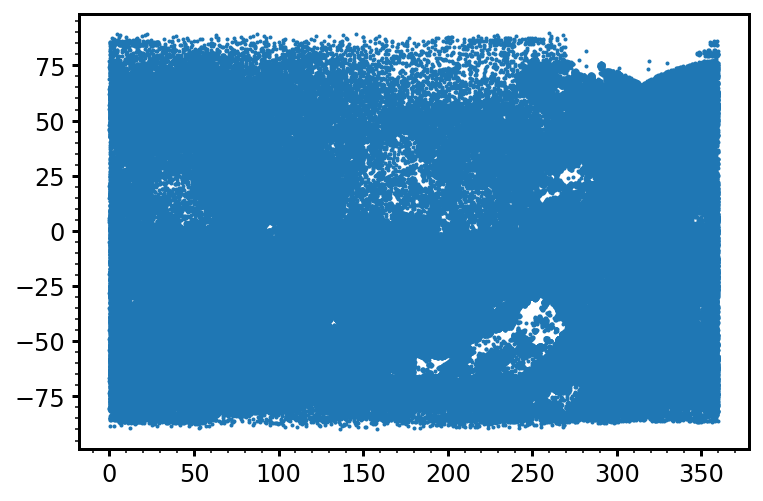

In [5]:
plt.scatter(kin['ra'],kin['dec'], s=1)

In [7]:
c = SkyCoord(kin['ra']*u.deg, kin['dec']*u.deg, frame='icrs')
ra_rad = c.ra.wrap_at(180 * u.deg).radian
dec_rad = c.dec.radian

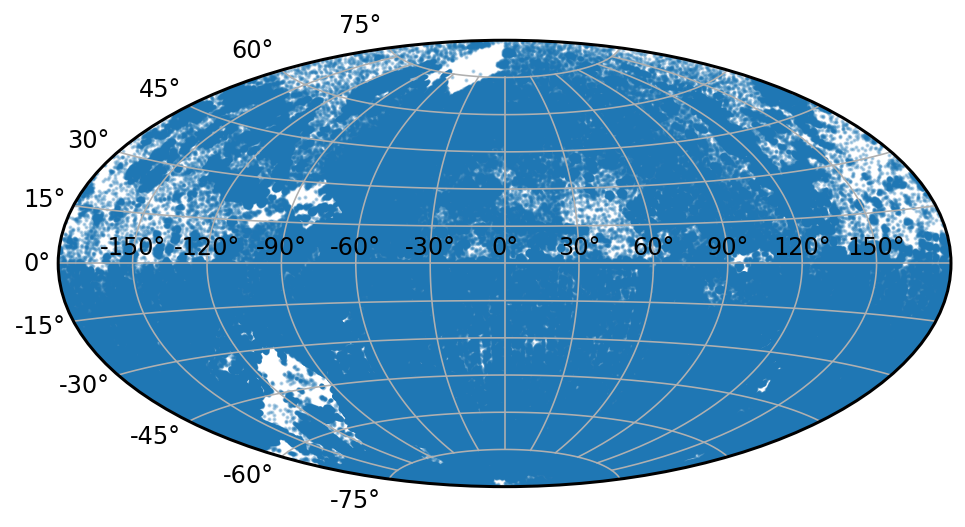

In [8]:
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.grid(True)
plt.plot(ra_rad, dec_rad, 'o', markersize=1, alpha=0.3, zorder=0)
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()

In [5]:
path = 'derived_parameters/' # use your path
all_files = glob.glob(os.path.join(path, "*.h5"))
rvs_params = pd.concat((pd.read_hdf(f) for f in all_files), ignore_index=True)

In [6]:
df_merged = pd.merge(kin, rvs_params, left_on='source_id', right_on='source_id')

In [217]:
print(len(df_merged['source_id']))
print(len(rvs_params['source_id']))

754071
1030972


In [71]:
df_merged.keys()

Index(['Unnamed: 0', 'source_id', 'ra', 'dec', 'parallax', 'model_teff',
       'model_logg', 'model_feh', 'model_mgfe', 'model_sife', 'model_cafe',
       'model_nife', 'err_teff', 'err_logg', 'err_feh', 'err_mgfe', 'err_sife',
       'err_cafe', 'err_nife', 'SNR', 'chisqs'],
      dtype='object')

In [7]:
c = SkyCoord(df_merged['ra']*u.deg, df_merged['dec']*u.deg, frame='icrs')
ra_rad = c.ra.wrap_at(180 * u.deg).radian
dec_rad = c.dec.radian

In [8]:
mgsi = df_merged['model_mgfe']/df_merged['model_sife']

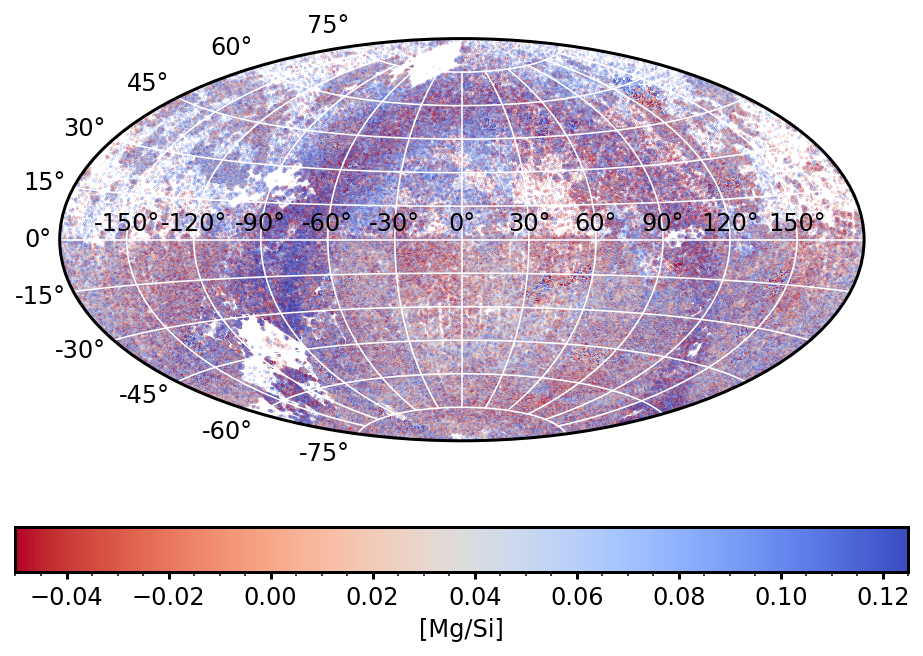

In [109]:
# Example of how to make an aitoff projection
mgsi_corr = df_merged['model_mgfe']- df_merged['model_sife']
plt.figure(figsize=(8,4.2))
plt.subplot(111, projection="aitoff")
plt.grid(True, c='white')
plt.scatter(ra_rad, dec_rad, c=mgsi_corr, s=.01, zorder=0, cmap='coolwarm_r', vmin=-.05,vmax=.125)
plt.subplots_adjust(top=0.95,bottom=0.0)
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label('[Mg/Si]',size=12)
plt.savefig('Paper_Figs/aitoff_mgsi_corr.png', dpi=300)